# RLHF: Reinforcement Learning from Human Feedback

**Goal**: Understand the full RLHF pipeline that aligns language models.

## The Three Steps of RLHF

```
Step 1: Supervised Fine-Tuning (SFT)
  Pretrained LM → Fine-tune on high-quality demonstrations → SFT Model

Step 2: Reward Modeling
  Collect human comparisons (response A > response B)
  Train a reward model to predict human preferences

Step 3: RL Fine-Tuning (PPO)
  Use PPO to optimize the SFT model against the reward model
  + KL penalty to prevent drifting too far from SFT model
```

We'll implement a **toy version** of each step to build intuition.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

torch.manual_seed(42)
np.random.seed(42)

---
## 1. The Toy Setup: Bandit Language Model

To focus on the RLHF mechanics without the complexity of a full LM, we'll use:

- **"Language model"**: A policy that picks from a vocabulary of 10 "tokens"
- **"Prompt"**: A context vector (one of 5 possible contexts)
- **"Response"**: A single token choice
- **Hidden preference**: Humans prefer certain tokens in certain contexts

This is a **contextual bandit** — the simplest version of the RLHF problem.

In [2]:
# Environment setup
N_CONTEXTS = 5
VOCAB_SIZE = 10
CONTEXT_DIM = 8

# Fixed context embeddings (like prompt embeddings)
context_embeddings = torch.randn(N_CONTEXTS, CONTEXT_DIM)

# Hidden "true" human preferences: for each context, some tokens are preferred
# This simulates the unknown reward function that RLHF tries to learn
true_preferences = torch.randn(N_CONTEXTS, VOCAB_SIZE)
true_preferences = torch.softmax(true_preferences * 2, dim=-1)  # Sharper preferences

def get_true_reward(context_id: int, token_id: int) -> float:
    """The hidden human preference (oracle). Higher = more preferred."""
    return true_preferences[context_id, token_id].item()

def get_human_comparison(context_id: int, token_a: int, token_b: int) -> int:
    """
    Simulate a human comparison (Bradley-Terry model).
    
    Returns 0 if token_a preferred, 1 if token_b preferred.
    """
    r_a = get_true_reward(context_id, token_a)
    r_b = get_true_reward(context_id, token_b)
    # Bradley-Terry: P(a > b) = exp(r_a) / (exp(r_a) + exp(r_b))
    prob_a = np.exp(r_a) / (np.exp(r_a) + np.exp(r_b))
    return 0 if np.random.random() < prob_a else 1

print("True preferences for context 0:")
for i in range(VOCAB_SIZE):
    bar = '█' * int(true_preferences[0, i].item() * 50)
    print(f"  Token {i}: {true_preferences[0, i]:.3f} {bar}")

True preferences for context 0:
  Token 0: 0.003 
  Token 1: 0.002 
  Token 2: 0.592 █████████████████████████████
  Token 3: 0.022 █
  Token 4: 0.033 █
  Token 5: 0.022 █
  Token 6: 0.252 ████████████
  Token 7: 0.006 
  Token 8: 0.001 
  Token 9: 0.065 ███


---
## 2. Step 1: SFT Model (Pre-trained Policy)

In real RLHF, this is a language model fine-tuned on demonstrations.
Here, we train a simple policy on some "demonstration" data.

In [3]:
class ToyLM(nn.Module):
    """Tiny 'language model': maps context → token distribution."""
    
    def __init__(self, context_dim: int, vocab_size: int, hidden_dim: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(context_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, vocab_size),
        )
    
    def forward(self, context):
        """Return logits over vocabulary."""
        return self.net(context)
    
    def get_distribution(self, context):
        """Return token probability distribution."""
        return Categorical(logits=self.forward(context))
    
    def generate(self, context_id: int) -> int:
        """Sample a token for a given context."""
        context = context_embeddings[context_id].unsqueeze(0)
        dist = self.get_distribution(context)
        return dist.sample().item()


# Create SFT model (random initialization = "pre-trained" model)
sft_model = ToyLM(CONTEXT_DIM, VOCAB_SIZE)

# Train SFT on some demonstration data
# (In practice: high-quality human-written responses)
sft_optimizer = optim.Adam(sft_model.parameters(), lr=1e-2)

# Generate demo data: sample good tokens based on true preferences
demo_contexts = []
demo_tokens = []
for _ in range(500):
    ctx = np.random.randint(N_CONTEXTS)
    # Sample from true preferences (demonstrations)
    token = torch.multinomial(true_preferences[ctx], 1).item()
    demo_contexts.append(ctx)
    demo_tokens.append(token)

# Train SFT
for epoch in range(100):
    indices = np.random.permutation(len(demo_contexts))
    total_loss = 0
    for i in range(0, len(indices), 32):
        batch_idx = indices[i:i+32]
        contexts = context_embeddings[torch.LongTensor([demo_contexts[j] for j in batch_idx])]
        targets = torch.LongTensor([demo_tokens[j] for j in batch_idx])
        
        logits = sft_model(contexts)
        loss = F.cross_entropy(logits, targets)
        
        sft_optimizer.zero_grad()
        loss.backward()
        sft_optimizer.step()
        total_loss += loss.item()

print("SFT training complete")

# Evaluate SFT model
sft_rewards = []
for ctx in range(N_CONTEXTS):
    rewards = [get_true_reward(ctx, sft_model.generate(ctx)) for _ in range(100)]
    sft_rewards.append(np.mean(rewards))
print(f"SFT avg reward: {np.mean(sft_rewards):.4f}")

SFT training complete
SFT avg reward: 0.5706


---
## 3. Step 2: Reward Model Training

Train a reward model from **pairwise comparisons** (not absolute scores).

### Bradley-Terry Model

$$P(y_w \succ y_l | x) = \sigma(r_\theta(x, y_w) - r_\theta(x, y_l))$$

Where:
- $y_w$ = preferred (winner) response
- $y_l$ = less preferred (loser) response
- $r_\theta$ = reward model
- $\sigma$ = sigmoid function

**Loss**: $\mathcal{L} = -\log \sigma(r_\theta(x, y_w) - r_\theta(x, y_l))$

In [4]:
class RewardModel(nn.Module):
    """Reward model: maps (context, token) → scalar reward."""
    
    def __init__(self, context_dim: int, vocab_size: int, hidden_dim: int = 32):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, hidden_dim)
        self.net = nn.Sequential(
            nn.Linear(context_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    
    def forward(self, context, token_ids):
        """
        Predict reward for (context, token) pairs.
        
        Args:
            context: Context embeddings [batch, context_dim]
            token_ids: Token indices [batch]
        
        Returns:
            Reward predictions [batch]
        """
        token_emb = self.token_embed(token_ids)
        combined = torch.cat([context, token_emb], dim=-1)
        return self.net(combined).squeeze(-1)

In [5]:
# Collect comparison data from "humans"
comparison_data = []  # (context_id, preferred_token, rejected_token)

for _ in range(2000):
    ctx = np.random.randint(N_CONTEXTS)
    token_a = np.random.randint(VOCAB_SIZE)
    token_b = np.random.randint(VOCAB_SIZE)
    if token_a == token_b:
        continue
    
    # Ask "human" which is better
    winner = get_human_comparison(ctx, token_a, token_b)
    if winner == 0:
        comparison_data.append((ctx, token_a, token_b))  # a preferred
    else:
        comparison_data.append((ctx, token_b, token_a))  # b preferred

print(f"Collected {len(comparison_data)} comparisons")

Collected 1784 comparisons


Final RM loss: 0.6669


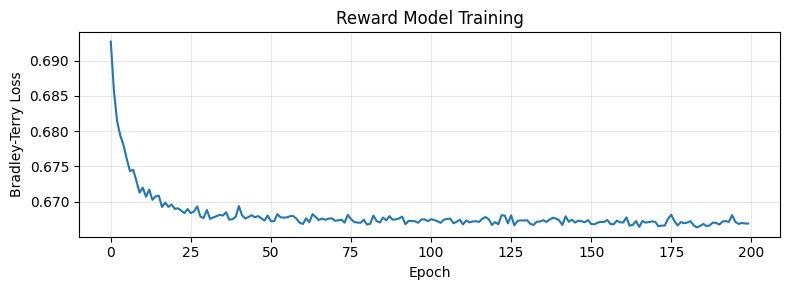

In [6]:
# Train reward model
reward_model = RewardModel(CONTEXT_DIM, VOCAB_SIZE)
rm_optimizer = optim.Adam(reward_model.parameters(), lr=1e-3)

losses = []
for epoch in range(200):
    indices = np.random.permutation(len(comparison_data))
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, len(indices), 64):
        batch_idx = indices[i:i+64]
        batch = [comparison_data[j] for j in batch_idx]
        
        ctx_ids = torch.LongTensor([b[0] for b in batch])
        win_ids = torch.LongTensor([b[1] for b in batch])
        lose_ids = torch.LongTensor([b[2] for b in batch])
        contexts = context_embeddings[ctx_ids]
        
        # Bradley-Terry loss
        r_win = reward_model(contexts, win_ids)
        r_lose = reward_model(contexts, lose_ids)
        loss = -F.logsigmoid(r_win - r_lose).mean()
        
        rm_optimizer.zero_grad()
        loss.backward()
        rm_optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    losses.append(epoch_loss / n_batches)

print(f"Final RM loss: {losses[-1]:.4f}")

# Plot RM training
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Bradley-Terry Loss')
plt.title('Reward Model Training')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Evaluate: does the reward model match true preferences?
print("Reward Model vs True Preferences (Context 0):\n")
print(f"{'Token':>6}  {'True Pref':>10}  {'RM Score':>10}")
print("-" * 30)

with torch.no_grad():
    ctx = context_embeddings[0].unsqueeze(0).expand(VOCAB_SIZE, -1)
    tokens = torch.arange(VOCAB_SIZE)
    rm_scores = reward_model(ctx, tokens).numpy()

true_prefs = true_preferences[0].numpy()
for i in range(VOCAB_SIZE):
    print(f"{i:>6}  {true_prefs[i]:>10.4f}  {rm_scores[i]:>10.4f}")

# Check rank correlation
from scipy.stats import spearmanr
corr, _ = spearmanr(true_prefs, rm_scores)
print(f"\nSpearman correlation: {corr:.3f} (1.0 = perfect ranking)")

Reward Model vs True Preferences (Context 0):

 Token   True Pref    RM Score
------------------------------
     0      0.0030      0.0229
     1      0.0025      0.1336
     2      0.5919      0.8260
     3      0.0218     -0.6026
     4      0.0330      0.0367
     5      0.0225      0.0796
     6      0.2524      0.5016
     7      0.0065      0.1036
     8      0.0014     -0.0423
     9      0.0651      0.0527

Spearman correlation: 0.515 (1.0 = perfect ranking)


---
## 4. Step 3: PPO Fine-Tuning with KL Penalty

The RLHF objective:

$$\max_\theta \mathbb{E}_{x, y \sim \pi_\theta} \left[ r_\phi(x, y) - \beta \cdot D_{KL}(\pi_\theta(\cdot|x) \| \pi_{ref}(\cdot|x)) \right]$$

**Two forces in tension**:
1. **Maximize reward model score** → generate preferred responses
2. **Stay close to reference (SFT) model** → don't collapse or hack the reward

In [8]:
def rlhf_train(
    policy: ToyLM,
    ref_model: ToyLM,
    reward_model: RewardModel,
    n_iterations: int = 500,
    batch_size: int = 32,
    lr: float = 1e-3,
    kl_coef: float = 0.1,
    clip_eps: float = 0.2,
) -> dict:
    """
    RLHF training loop (simplified PPO with KL penalty).
    
    Args:
        policy: The model to optimize
        ref_model: Frozen reference (SFT) model
        reward_model: Trained reward model
        n_iterations: Number of PPO updates
        batch_size: Samples per update
        lr: Learning rate
        kl_coef: KL penalty coefficient (β)
        clip_eps: PPO clipping parameter
    
    Returns:
        Training metrics
    """
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    reward_history = []
    kl_history = []
    objective_history = []
    
    for iteration in range(n_iterations):
        # Sample contexts
        ctx_ids = torch.randint(0, N_CONTEXTS, (batch_size,))
        contexts = context_embeddings[ctx_ids]
        
        # Get old policy distribution (for PPO ratio)
        with torch.no_grad():
            old_logits = policy(contexts)
            old_dist = Categorical(logits=old_logits)
        
        # Sample tokens from current policy
        tokens = old_dist.sample()
        old_log_probs = old_dist.log_prob(tokens)
        
        # Get rewards from reward model
        with torch.no_grad():
            rewards = reward_model(contexts, tokens)
        
        # Compute KL divergence from reference model
        with torch.no_grad():
            ref_logits = ref_model(contexts)
            ref_dist = Categorical(logits=ref_logits)
        
        # Current policy (for gradient)
        new_logits = policy(contexts)
        new_dist = Categorical(logits=new_logits)
        new_log_probs = new_dist.log_prob(tokens)
        
        # KL(π_θ || π_ref) per sample
        kl = torch.distributions.kl_divergence(new_dist, ref_dist)
        
        # RLHF reward = RM score - β * KL
        rlhf_reward = rewards - kl_coef * kl
        
        # Normalize advantages
        advantages = (rlhf_reward - rlhf_reward.mean()) / (rlhf_reward.std() + 1e-8)
        
        # PPO clipped objective
        ratio = torch.exp(new_log_probs - old_log_probs.detach())
        surr1 = ratio * advantages.detach()
        surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * advantages.detach()
        policy_loss = -torch.min(surr1, surr2).mean()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        reward_history.append(rewards.mean().item())
        kl_history.append(kl.mean().item())
        objective_history.append(rlhf_reward.mean().item())
        
        if (iteration + 1) % 100 == 0:
            print(f"Iter {iteration+1}: reward={rewards.mean():.4f}, "
                  f"KL={kl.mean():.4f}, objective={rlhf_reward.mean():.4f}")
    
    return {
        'rewards': reward_history,
        'kl': kl_history,
        'objective': objective_history,
    }

In [9]:
import copy

# Create RLHF policy (copy of SFT model)
rlhf_policy = copy.deepcopy(sft_model)
# Freeze reference model
ref_model = copy.deepcopy(sft_model)
for p in ref_model.parameters():
    p.requires_grad = False

# Run RLHF training
print("Starting RLHF training...\n")
rlhf_metrics = rlhf_train(
    policy=rlhf_policy,
    ref_model=ref_model,
    reward_model=reward_model,
    n_iterations=500,
    kl_coef=0.1,
)

Starting RLHF training...

Iter 100: reward=0.6268, KL=0.2752, objective=0.5993
Iter 200: reward=0.6703, KL=0.6419, objective=0.6061
Iter 300: reward=0.6066, KL=0.6827, objective=0.5383
Iter 400: reward=0.6642, KL=0.5964, objective=0.6045
Iter 500: reward=0.7560, KL=0.5283, objective=0.7032


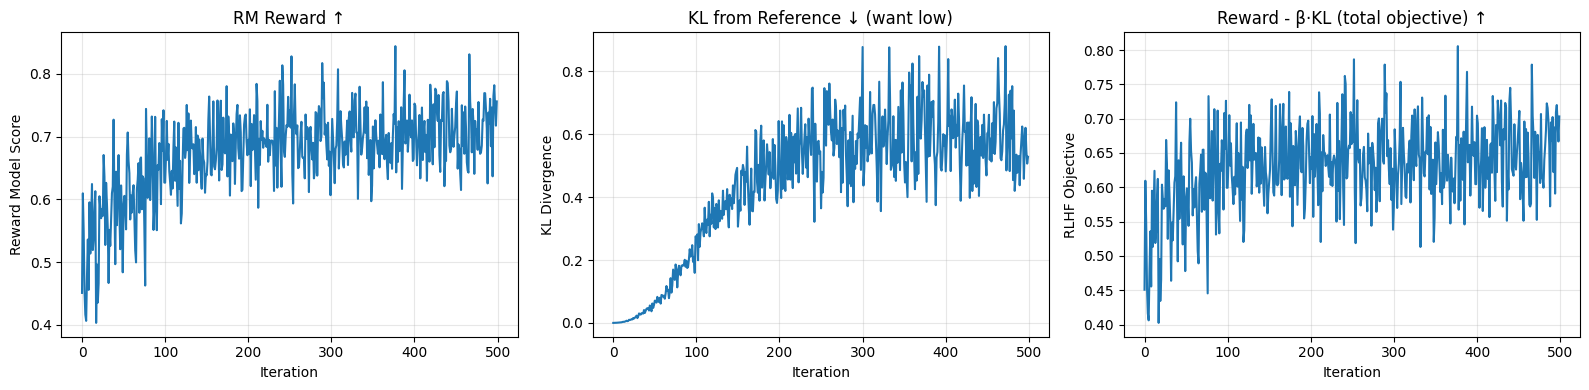

In [10]:
# Plot RLHF training
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ax = axes[0]
ax.plot(rlhf_metrics['rewards'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Reward Model Score')
ax.set_title('RM Reward ↑')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(rlhf_metrics['kl'])
ax.set_xlabel('Iteration')
ax.set_ylabel('KL Divergence')
ax.set_title('KL from Reference ↓ (want low)')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(rlhf_metrics['objective'])
ax.set_xlabel('Iteration')
ax.set_ylabel('RLHF Objective')
ax.set_title('Reward - β·KL (total objective) ↑')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Compare SFT vs RLHF policy
print("Performance comparison (true reward):\n")

sft_total, rlhf_total = 0, 0
for ctx in range(N_CONTEXTS):
    sft_r = np.mean([get_true_reward(ctx, sft_model.generate(ctx)) for _ in range(200)])
    rlhf_r = np.mean([get_true_reward(ctx, rlhf_policy.generate(ctx)) for _ in range(200)])
    print(f"Context {ctx}: SFT={sft_r:.4f}  RLHF={rlhf_r:.4f}  {'✓ improved' if rlhf_r > sft_r else '✗ worse'}")
    sft_total += sft_r
    rlhf_total += rlhf_r

print(f"\nOverall: SFT={sft_total/N_CONTEXTS:.4f}  RLHF={rlhf_total/N_CONTEXTS:.4f}")

Performance comparison (true reward):

Context 0: SFT=0.3617  RLHF=0.5919  ✓ improved
Context 1: SFT=0.2656  RLHF=0.4768  ✓ improved
Context 2: SFT=0.7423  RLHF=0.8543  ✓ improved
Context 3: SFT=0.3442  RLHF=0.1415  ✗ worse
Context 4: SFT=0.9925  RLHF=0.9925  ✗ worse

Overall: SFT=0.5413  RLHF=0.6114


---
## 5. The KL Penalty: Why It Matters

In [12]:
# Ablation: different KL coefficients
kl_results = {}

for beta in [0.0, 0.01, 0.1, 1.0]:
    print(f"\nTraining with β={beta}...")
    policy = copy.deepcopy(sft_model)
    metrics = rlhf_train(
        policy=policy,
        ref_model=ref_model,
        reward_model=reward_model,
        n_iterations=300,
        kl_coef=beta,
    )
    kl_results[f"β={beta}"] = metrics


Training with β=0.0...
Iter 100: reward=0.6578, KL=0.2897, objective=0.6578
Iter 200: reward=0.8200, KL=0.4765, objective=0.8200
Iter 300: reward=0.6242, KL=0.6871, objective=0.6242

Training with β=0.01...
Iter 100: reward=0.6092, KL=0.2762, objective=0.6064
Iter 200: reward=0.6568, KL=0.6170, objective=0.6506
Iter 300: reward=0.7331, KL=0.5497, objective=0.7276

Training with β=0.1...
Iter 100: reward=0.5558, KL=0.2155, objective=0.5342
Iter 200: reward=0.7010, KL=0.5788, objective=0.6431
Iter 300: reward=0.6906, KL=0.5752, objective=0.6331

Training with β=1.0...
Iter 100: reward=0.6295, KL=0.2794, objective=0.3500
Iter 200: reward=0.7588, KL=0.3983, objective=0.3605
Iter 300: reward=0.7373, KL=0.4858, objective=0.2515


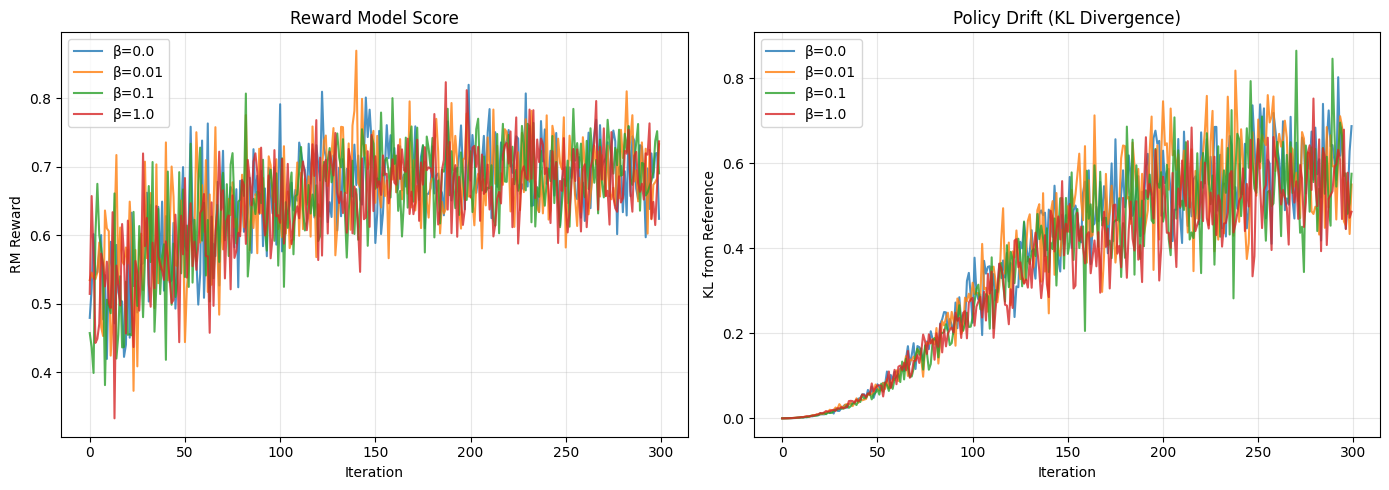


Key insight:
  β=0: Highest reward but huge KL → reward hacking!
  β=1: Low KL but barely improves → too conservative
  β=0.1: Good balance → improves while staying close to SFT


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
for label, data in kl_results.items():
    ax.plot(data['rewards'], label=label, alpha=0.8)
ax.set_xlabel('Iteration')
ax.set_ylabel('RM Reward')
ax.set_title('Reward Model Score')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
for label, data in kl_results.items():
    ax.plot(data['kl'], label=label, alpha=0.8)
ax.set_xlabel('Iteration')
ax.set_ylabel('KL from Reference')
ax.set_title('Policy Drift (KL Divergence)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey insight:")
print("  β=0: Highest reward but huge KL → reward hacking!")
print("  β=1: Low KL but barely improves → too conservative")
print("  β=0.1: Good balance → improves while staying close to SFT")

---
## 6. Reward Hacking

When β is too low, the policy **exploits** the reward model:
- Finds patterns that get high RM scores but aren't actually good
- The RM is imperfect → policy finds its blind spots
- In practice: repetitive text, sycophantic responses, format gaming

**The KL penalty prevents this** by keeping the model close to the "sane" SFT baseline.

This is one of the key motivations for **DPO** — avoid the reward model entirely.

---
## Key Takeaways

1. **RLHF has 3 steps**: SFT → Reward Model → PPO fine-tuning

2. **Reward model** learns from pairwise human comparisons using Bradley-Terry

3. **PPO + KL penalty** optimizes reward while preventing drift from reference model

4. **β (KL coefficient)** is critical: too low → reward hacking, too high → no improvement

5. **Reward hacking** is a fundamental challenge — the policy exploits RM imperfections

### RLHF Challenges
- Requires training a separate reward model
- PPO is complex and sensitive to hyperparameters
- Reward hacking is hard to prevent fully
- KL coefficient needs tuning

→ **DPO solves several of these problems!**